# Imports

In [1]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from dateutil.parser import parse
from datetime import timedelta
import pprint as pp

In [2]:
# Read in the pandas.DataFrame from csv
data = pd.read_csv('../DataAnalysis/RandomForest/ebay_data_rf.csv', index_col=False)

# Random forest model

Our eBay data contains primarily categorical variables. Thus, random forest is a natural option for modeling the dataset, because the random forest algorithm is based on decision trees which naturally handle categorical data.

## Preprocessing

In [3]:
# Separate target variable from inputs
y = data.sellingState
T = data.endTime
X = data.drop(['sellingState','endTime'], axis=1)
T_dt = [parse(x) for x in T]

In [4]:
# Calculate the sample weights
def get_days_diff(dt1 , dt2): 
    return (dt1 - dt2).total_seconds()/(86400) 
    # 86400 s/day = 60 s/min * 60 min/hr *24 hr/day

def get_weight(dt, dt_ref, sigma):

    hrs = get_days_diff(dt,dt_ref)
    
    return math.exp( -hrs**2 / (2 * sigma) )

def get_sample_weights(dt_ls, sigma):
    latest = max(dt_ls)
    return [get_weight(x, latest, sigma) for x in dt_ls]

sw = get_sample_weights(T_dt, 2)

In [5]:
# Split the data into train and test. 
#Since we are going to optimize sigma, we split into old and new
test_ind = range(0,1000)
train_ind = range(1000,len(y))

X_train = X.iloc[train_ind]
X_test = X.iloc[test_ind]
y_train = y[list(train_ind)]
y_test = y[list(test_ind)]

T_dt_train = T_dt[1000:len(y)]

In [6]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))
print(len(T_dt_train))

(9000, 20)
(1000, 20)
9000
1000
9000


## Classification

In [7]:
# Assign the classifier
n_estimators = 140
max_features = None
weights = {0: 1, 1: 1}
RANDOM_STATE = 52
clf = RandomForestClassifier(n_estimators = n_estimators,
                             max_features=max_features,
                             class_weight=weights,
                             oob_score=False,
                             n_jobs = 4,
                             random_state = RANDOM_STATE
                            )

In [8]:
# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
aucs = []

# Range of sigma to explore (in days)
min_sigma = 1
max_sigma = 60

for sig in range(min_sigma, max_sigma+1,1):
    sw = get_sample_weights(T_dt_train, sig)
    clf.fit(X_train, y_train, sw)
    y_pred = clf.predict_proba(X_test)[:,1]
    aucs.append( (sig, roc_auc_score(y_test, y_pred)) )
    
aucs

[(1, 0.80928980359720404),
 (2, 0.8165961173551306),
 (3, 0.82148794174410866),
 (4, 0.82549992701795361),
 (5, 0.83195072900955269),
 (6, 0.83257107640409356),
 (7, 0.833902998751196),
 (8, 0.83451523702946862),
 (9, 0.83443414586678344),
 (10, 0.83558969493504587),
 (11, 0.83230753012536685),
 (12, 0.83401652637895518),
 (13, 0.83494299291263241),
 (14, 0.83522275742389596),
 (15, 0.83426182714607755),
 (16, 0.83571944079534211),
 (17, 0.83201154738156635),
 (18, 0.83458416451775075),
 (19, 0.83634789730615156),
 (20, 0.83520451191229195),
 (21, 0.83595257788806188),
 (22, 0.8331468236591576),
 (23, 0.83572957719067775),
 (24, 0.83847856760570239),
 (25, 0.83808122090854531),
 (26, 0.83940300686031233),
 (27, 0.83901985111662536),
 (28, 0.83882320504711394),
 (29, 0.83851911318704475),
 (30, 0.83931988841856009),
 (31, 0.83671280753823452),
 (32, 0.83777915632754341),
 (33, 0.83502408407531736),
 (34, 0.83356444314698575),
 (35, 0.83443211858771626),
 (36, 0.83714664525859972),
 (37,

## Test the model on the test set

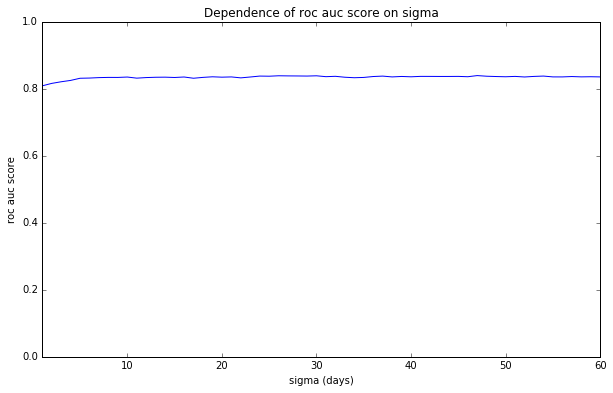

In [11]:
xs, ys = zip(*aucs)

plt.plot(xs, ys)

plt.title("Dependence of roc auc score on sigma")
plt.xlim(min_sigma, max_sigma)
plt.ylim(0,1)
plt.xlabel("sigma (days)")
plt.ylabel("roc auc score")

plt.show()

The roc auc score settles down for sigma > 10 days.